### 1. 切換 TensorFlow 版本及匯入所需套件

In [0]:
%tensorflow_version 2.x

In [0]:
import numpy as np
import matplotlib.pyplot as plt

In [0]:
# Import some useful packages
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, IntSlider, FloatSlider

import tensorflow as tf
import tensorflow.keras.backend as K

# Layers for FNN
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Lambda, concatenate
from tensorflow.keras.layers import Dense

# Optimizers for training
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import metrics

# Losses for training
from tensorflow.keras import losses

# For data preprocessing
from tensorflow.keras import datasets
from tensorflow.keras.utils import to_categorical

### 2. 下載並整理資料集(MNIST)

In [4]:
# Load dataset
(X_train, y_train0), (X_test, y_test0) = datasets.mnist.load_data()

# Reshape size
X_train = X_train.reshape(-1, 28*28)
X_test = X_test.reshape(-1, 28*28)

# Normalize the range of featurs
X_train = X_train / X_train.max()
X_test = X_test / X_test.max()

# One-hot encoding
y_train = to_categorical(y_train0, 10)
y_test = to_categorical(y_test0, 10)

11493376/11490434 [==============================] - 0s 0us/step


### 3. 建立VAE 
#### (以助教上課所建立的架構為主，修改參數並進行測試)

#### 修正項目
* 在encoder和decoder各增加一層，並修改各層參數
* 嘗試用relu作為激活函數

In [0]:
enc_1 = Dense(512, activation='sigmoid')
enc_2 = Dense(256, activation='relu')

enc_mean = Dense(2)
enc_log_var = Dense(2)

dec_3 = Dense(350, activation='relu')
dec_2 = Dense(500, activation='sigmoid')
dec_1 = Dense(784, activation='sigmoid')

In [0]:
x = Input(shape=(784,))
enc_x = enc_2(enc_1(x))

z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)

In [0]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [0]:
# Sampling function wrapped as a Keras layer
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])

In [0]:
# Define Decoder part of VAE
z_input = Input(shape=(2,))
x_hat = dec_1(dec_2(dec_3(z_input)))

In [10]:
x_hat = dec_1(dec_2(dec_3(z)))

VAE = Model(x, x_hat)
VAE.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          401920      input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          131328      dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            514         dense_1[0][0]                    
______________________________________________________________________________________________

### 4. 建立Loss函數

In [0]:
# reconstruction_loss = tf.keras.losses.mse(inputs, outputs)
reconstruction_loss = 784 * losses.mean_squared_error(x, x_hat)

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = K.mean(reconstruction_loss + kl_loss)

VAE.add_loss(vae_loss)

### 5. 訓練VAE

In [0]:
VAE.compile(optimizer=Adam())

修改項目:
* batch_size下修至256
* epochs增加至10次

In [13]:
VAE.fit(X_train, X_train, 
        batch_size=256, 
        epochs=10)

Epoch 1/10
235/235 [==============================] - 8s 32ms/step - loss: 53.1389
Epoch 2/10
235/235 [==============================] - 8s 32ms/step - loss: 45.4094
Epoch 3/10
235/235 [==============================] - 8s 32ms/step - loss: 42.9104
Epoch 4/10
235/235 [==============================] - 8s 35ms/step - loss: 41.3823
Epoch 5/10
235/235 [==============================] - 8s 32ms/step - loss: 40.3274
Epoch 6/10
235/235 [==============================] - 8s 32ms/step - loss: 39.4951
Epoch 7/10
235/235 [==============================] - 8s 32ms/step - loss: 38.9042
Epoch 8/10
235/235 [==============================] - 7s 32ms/step - loss: 38.3755
Epoch 9/10
235/235 [==============================] - 8s 32ms/step - loss: 37.9447
Epoch 10/10
235/235 [==============================] - 8s 32ms/step - loss: 37.5431


### 6. VAE的視覺化

In [14]:
VAE_Encoder = Model(x, z_mean)

VAE_Encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 514       
Total params: 533,762
Trainable params: 533,762
Non-trainable params: 0
_________________________________________________________________


In [15]:
VAE_Decoder = Model(z_input, dec_1(dec_2(dec_3(z_input))))

VAE_Decoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 350)               1050      
_________________________________________________________________
dense_5 (Dense)              (None, 500)               175500    
_________________________________________________________________
dense_6 (Dense)              (None, 784)               392784    
Total params: 569,334
Trainable params: 569,334
Non-trainable params: 0
_________________________________________________________________


先進行Encoder的視覺化呈現。

In [16]:
idx = np.random.randint(X_train.shape[0])
print(f"第 {idx} 圖的 latent 表示為 {VAE_Encoder.predict(X_train[idx: idx+1]).squeeze()}")

第 50116 圖的 latent 表示為 [-1.587685   -0.21983068]


In [0]:
indices = np.random.randint(X_train.shape[0], size=3000)

In [0]:
VAE_latents = VAE_Encoder.predict(X_train[indices])

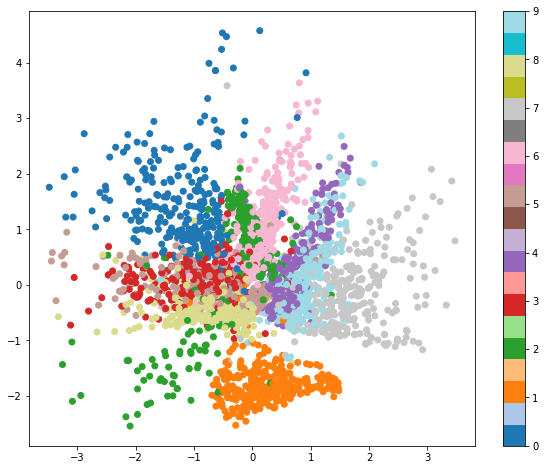

In [19]:
plt.figure(figsize=(10, 8))
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_train0[indices], cmap='tab20')
plt.colorbar()
plt.show()

再進行Decoder的視覺化呈現。

In [0]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

In [0]:
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

In [0]:
grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = normalized(digit)

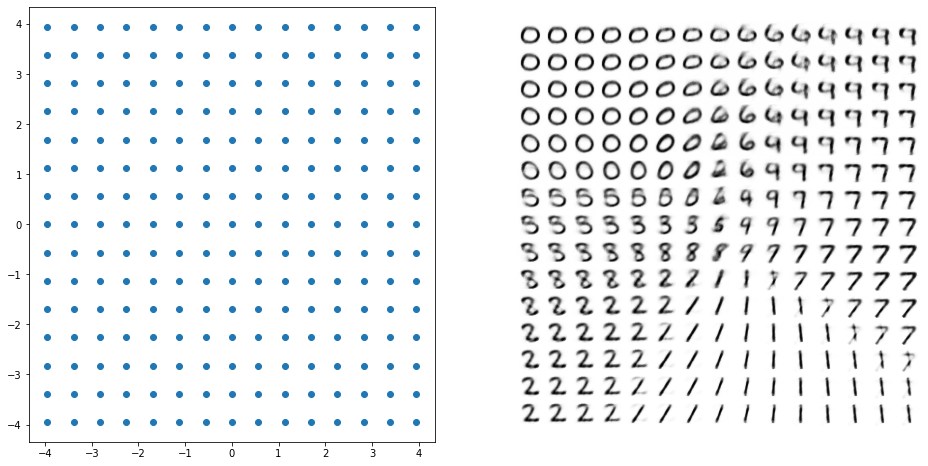

In [36]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
XXX, YYY = np.meshgrid(grid_x_vae, grid_y_vae)
plt.scatter(XXX, YYY)

plt.subplot(1, 2, 2)
plt.imshow(VAE_figure, cmap='Greys')
plt.axis('off')
plt.show()

### 7. 動態比較

In [0]:
idx_1, idx_2 = np.random.randint(X_train.shape[0], size=2)

In [0]:
def inBetween(t):
    data_0 = X_train[idx_1].reshape(28, 28)
    data_1 = X_train[idx_2].reshape(28, 28)
    data_t = (1-t)*data_0 + t*data_1
    
    mu_0 = VAE_Encoder.predict(X_train[idx_1:idx_1+1]).squeeze()
    mu_1 = VAE_Encoder.predict(X_train[idx_2:idx_2+1]).squeeze()
    mu_t = (1-t)*mu_0 + t*mu_1

    plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(2, 1, 2)
    ax1.scatter(mu_0[0], mu_0[1])
    ax1.scatter(mu_1[0], mu_1[1])
    ax1.scatter(mu_t[0], mu_t[1])

    ax2 = plt.subplot(2, 3, 1)
    ax2.imshow(data_0, cmap='Greys')
    ax2.set_title('t=0')

    ax3 = plt.subplot(2, 3, 2)
    ax3.imshow(data_t, cmap='Greys')
    ax3.set_title(f't={t}')

    ax4 = plt.subplot(2, 3, 3)
    ax4.imshow(data_1, cmap='Greys')
    ax4.set_title('t=1')

In [25]:
interact(inBetween, t=FloatSlider(value=0, 
                                  min=0, 
                                  max=1.0,
                                  step=0.02,))

interactive(children=(FloatSlider(value=0.0, description='t', max=1.0, step=0.02), Output()), _dom_classes=('w…

<function __main__.inBetween>